# Conditional Deep Convolutional Generative Adversarial Network (CDCGAN) 

In [1]:
#Import the libraries we will need.
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import os
import scipy.misc
import scipy

We will be using the MNIST dataset. input_data is a library that downloads the dataset and uzips it automatically. It can be acquired Github here: https://gist.github.com/awjuliani/1d21151bc17362bf6738c3dc02f37906

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


(55000, 28, 28)
(55000,)


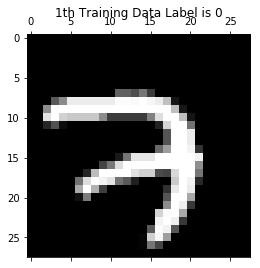

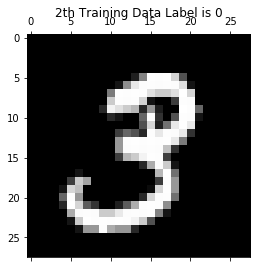

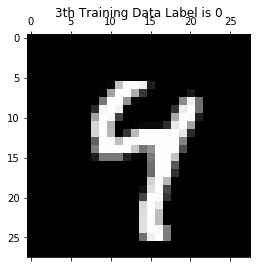

In [3]:
#print out several data in mnist
trainimg = mnist.train.images
train_y = mnist.train.labels
nsample = 1
randidx = np.random.randint(trainimg.shape[0], size=nsample)

train_x = np.reshape(trainimg,(trainimg.shape[0],28,28))
print(train_x.shape)
print(train_y.shape)

for i in [0, 1, 2]:
    curr_img   = np.reshape(trainimg[i, :], (28, 28)) # 28 by 28 matrix 
    curr_label = np.argmax(train_y[i] ) # Label
    plt.matshow(curr_img, cmap=plt.get_cmap('gray'))
    plt.title("" + str(i + 1) + "th Training Data " 
              + "Label is " + str(curr_label))

### Helper Functions

In [4]:
#This function performns a leaky relu activation, which is needed for the discriminator network.
NUM_LABELS = 47
rnd = np.random.RandomState(123)
tf.set_random_seed(123)
batch_size = 128
IMG_CHN = 1

def lrelu(x, leak=0.2, name="lrelu"):
     with tf.variable_scope(name):
         f1 = 0.5 * (1 + leak)
         f2 = 0.5 * (1 - leak)
         return f1 * x + f2 * abs(x)
    
#The below functions are taken from carpdem20's implementation https://github.com/carpedm20/DCGAN-tensorflow
#They allow for saving sample images from the generator to follow progress
def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)

def imsave(images, size, path):
    return scipy.misc.imsave(path, merge(images, size))

def inverse_transform(images):
    return (images+1.)/2.

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1]))

    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w] = image

    return img

def upsample(input, name, factor=[2,2]):
    size = [int(input.shape[1] * factor[0]), int(input.shape[2] * factor[1])]
    with tf.name_scope(name):
        out = tf.image.resize_nearest_neighbor(input, size=size, align_corners=False, name=None)
        return out

## Defining the Adversarial Networks

### CAE as image feature extractor for condition input

In [5]:
def cae_encoder(x, reuse = False):
    
    c1 = slim.convolution2d(x, 32, [3,3], stride=[1,1], padding="SAME",\
        biases_initializer=None,activation_fn=lrelu,\
        reuse=reuse,scope='conv1')
    
    p1 = slim.max_pool2d(c1, [2, 2], scope='pool1')
    
    c2 = slim.convolution2d(p1, 64, [3,3], stride=[2,2], padding="SAME",\
        biases_initializer=None,activation_fn=lrelu,\
        reuse=reuse,scope='conv2')
    
    c3 = slim.convolution2d(c2, 64, [3,3], stride=[1,1], padding="SAME",\
        biases_initializer=None,activation_fn=lrelu,\
        reuse=reuse,scope='conv3')

    e_out = slim.max_pool2d(c3, [2, 2], scope='pool2')
    
    return e_out

def cae_decoder(f, reuse = False):
    
    up1 = upsample(f, name = "up1")

    dc_1 = slim.convolution2d_transpose(\
        up1,num_outputs=64, kernel_size=[3,3],stride=[1,1],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='dconv_1' )

    dc_2 = slim.convolution2d_transpose(\
        dc_1, num_outputs=32, kernel_size=[3,3],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='dconv_2' )


    up2 = upsample(dc_2, name = "up2")

    dc_3 = slim.convolution2d_transpose(\
        up2, num_outputs=IMG_CHN, kernel_size=[3,3],stride=[1,1],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.sigmoid,scope='dconv_3' )

    return dc_3



### Generator Network

The generator takes a vector of random numbers and transforms it into a 32x32 image. Each layer in the network involves a strided  transpose convolution, batch normalization, and rectified nonlinearity. Tensorflow's slim library allows us to easily define each of these layers.

In [6]:
def generator(z, c):
    
    with tf.variable_scope("gan"):
    
        zcP = tf.concat([z, c],1)

        g_in = slim.fully_connected(zcP,4*4*128,normalizer_fn= slim.batch_norm,\
            activation_fn=tf.nn.relu,scope='g_project')

        g_in_Con = tf.reshape(g_in,[-1,4,4,128])

        gen1 = slim.convolution2d_transpose(\
            g_in_Con,num_outputs=64,kernel_size=[5,5],stride=[2,2],\
            padding="SAME",normalizer_fn=slim.batch_norm,\
            activation_fn=tf.nn.relu,scope='g_conv1')

        gen2 = slim.convolution2d_transpose(\
            gen1,num_outputs=32,kernel_size=[5,5],stride=[2,2],\
            padding="SAME",normalizer_fn=slim.batch_norm,\
            activation_fn=tf.nn.relu,scope='g_conv2')

        gen3 = slim.convolution2d_transpose(\
            gen2,num_outputs=16,kernel_size=[5,5],stride=[2,2],\
            padding="SAME",normalizer_fn=slim.batch_norm,\
            activation_fn=tf.nn.relu,scope='g_conv3')

        g_out = slim.convolution2d_transpose(\
            gen3,num_outputs=1,kernel_size=[32,32],padding="SAME",\
            biases_initializer=None,activation_fn=tf.nn.tanh,\
            scope='g_out')

    return g_out

### Discriminator Network
The discriminator network takes as input a 32x32 image and transforms it into a single valued probability of being generated from real-world data. Again we use tf.slim to define the convolutional layers, batch normalization, and weight initialization.

In [7]:
def discriminator(img, c, reuse=False):
    
    with tf.variable_scope("gan"):

        dis1 = slim.convolution2d(img,16,[4,4],stride=[2,2],padding="SAME",\
            biases_initializer=None,activation_fn=lrelu,\
            reuse=reuse,scope='d_conv1')

        dis2 = slim.convolution2d(dis1,32,[4,4],stride=[2,2],padding="SAME",\
            normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
            reuse=reuse,scope='d_conv2')

        dis3 = slim.convolution2d(dis2,32,[4,4],stride=[2,2],padding="SAME",\
            normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
            reuse=reuse,scope='d_conv3')

        d_fc1 = slim.fully_connected(slim.flatten(dis1),512,activation_fn=tf.nn.relu,\
            reuse=reuse,scope='d_fc1')

        d_combined =  tf.concat([d_fc1, c],1)


        d_fc2 = slim.fully_connected(slim.flatten(d_combined),128,activation_fn=tf.nn.relu,\
            reuse=reuse,scope='d_fc2')

        d_out= slim.fully_connected(slim.flatten(d_combined),1,activation_fn=tf.nn.sigmoid,\
            reuse=reuse,scope='d_out')

    return d_out

### Connecting them together

In [8]:
tf.reset_default_graph()

z_size = 100 #Size of z vector used for generator.

#These two placeholders are used for input into the generator and discriminator, respectively.

z_in = tf.placeholder(shape=[None,z_size],dtype=tf.float32) #Random vector
c_in = tf.placeholder(shape = [None,32,32,IMG_CHN],dtype = tf.float32) # conditional input
real_in = tf.placeholder(shape=[None,32,32,IMG_CHN],dtype=tf.float32) #Real images

'''
Define GAN graph
'''
fx = cae_encoder(c_in)
model_directory = '../../CAE/models' #Directory to load trained model from.

saver = tf.train.Saver()

with tf.Session() as sess:  
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    #Reload CAE the model
    ckpt = tf.train.get_checkpoint_state(model_directory)
    saver.restore(sess,ckpt.model_checkpoint_path)
    print("CAE restored.")
    
c_in_flat = tf.layers.Flatten()(fx)
Gz = generator(z_in, c_in_flat) #Generates images from random z vectors
Dx = discriminator(real_in, c_in_flat) #Produces probabilities for real images
Dg = discriminator(Gz,c_in_flat,reuse=True) #Produces probabilities for generator images

#These functions together define the optimization objective of the GAN.
d_loss = -tf.reduce_mean(tf.log(Dx) + tf.log(1.-Dg)) #This optimizes the discriminator.
g_loss = -tf.reduce_mean(tf.log(Dg)) #This optimizes the generator.

tvars = tf.trainable_variables()

#The below code is responsible for applying gradient descent to update the GAN.
trainerD = tf.train.AdamOptimizer(learning_rate=0.0005,beta1=0.5)
trainerG = tf.train.AdamOptimizer(learning_rate=0.0005,beta1=0.5)
d_grads = trainerD.compute_gradients(d_loss,tvars[9:]) #Only update the weights for the discriminator network.
g_grads = trainerG.compute_gradients(g_loss,tvars[0:9]) #Only update the weights for the generator network.

update_D = trainerD.apply_gradients(d_grads)
update_G = trainerG.apply_gradients(g_grads)

INFO:tensorflow:Restoring parameters from ../../CAE/models\model-4000.cptk
CAE restored.


## Training the network


In [11]:
batch_size = 128 #Size of image batch to apply at each iteration.
iterations = 500000 #Total number of iterations to use.
sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to save trained model to.


saver = tf.train.Saver()

GAN_list = tf.get_collection(
    tf.GraphKeys.GLOBAL_VARIABLES, 
    scope="gan"
)

gan_init = tf.variables_initializer(GAN_list)

with tf.Session() as sess:  
    sess.run(tf.global_variables_initializer())
    sess.run(gan_init)
    
    for i in range(iterations):
        print(i)
        zs = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate a random z batch
        xs,_ = mnist.train.next_batch(batch_size) #Draw a sample batch from MNIST dataset.
        xs = (np.reshape(xs,[batch_size,28,28,1]) - 0.5) * 2.0 #Transform it to be between -1 and 1
        xs = np.lib.pad(xs, ((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1)) #Pad the images so the are 32x32
        
        _,dLoss = sess.run([update_D,d_loss],feed_dict={z_in:zs,real_in:xs, c_in:xs }) #Update the discriminator
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs, c_in:xs}) #Update the generator, twice for good measure.
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs, c_in:xs})
        
        break

        if i % 10 == 0:
            print("Gen Loss: " + str(gLoss) + " Disc Loss: " + str(dLoss))
            z2 = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate another z batch
            newZ = sess.run(Gz,feed_dict={z_in:z2, c_in:xs}) #Use new z to get sample images from generator.
            if not os.path.exists(sample_directory):
                os.makedirs(sample_directory)
            #Save sample generator images for viewing training progress.
            save_images(np.reshape(newZ[0:36],[36,32,32]),[6,6],sample_directory+'/fig'+str(i)+'.png')
        if i % 1000 == 0 and i != 0:
            if not os.path.exists(model_directory):
                os.makedirs(model_directory)
            saver.save(sess,model_directory+'/model-'+str(i)+'.cptk')
            print("Saved Model")

ResourceExhaustedError: OOM when allocating tensor of shape [4096,512] and type float
	 [[Node: gan/d_fc1/weights/Adam/Initializer/zeros = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [4096,512] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'gan/d_fc1/weights/Adam/Initializer/zeros', defined at:
  File "c:\program files\python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\program files\python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\program files\python36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\program files\python36\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\program files\python36\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "c:\program files\python36\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "c:\program files\python36\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "c:\program files\python36\lib\asyncio\base_events.py", line 1432, in _run_once
    handle._run()
  File "c:\program files\python36\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "c:\program files\python36\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "c:\program files\python36\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\program files\python36\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "c:\program files\python36\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\program files\python36\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "c:\program files\python36\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\program files\python36\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\program files\python36\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\program files\python36\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "c:\program files\python36\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\program files\python36\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\program files\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\program files\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\program files\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\program files\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-2b45e58feabe>", line 45, in <module>
    update_D = trainerD.apply_gradients(d_grads)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\training\optimizer.py", line 600, in apply_gradients
    self._create_slots(var_list)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\training\adam.py", line 131, in _create_slots
    self._zeros_slot(v, "m", self._name)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\training\optimizer.py", line 1150, in _zeros_slot
    new_slot_variable = slot_creator.create_zeros_slot(var, op_name)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\training\slot_creator.py", line 181, in create_zeros_slot
    colocate_with_primary=colocate_with_primary)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\training\slot_creator.py", line 155, in create_slot_with_initializer
    dtype)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\training\slot_creator.py", line 65, in _create_slot_var
    validate_shape=validate_shape)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1317, in get_variable
    constraint=constraint)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1079, in get_variable
    constraint=constraint)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 425, in get_variable
    constraint=constraint)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 394, in _true_getter
    use_resource=use_resource, constraint=constraint)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 786, in _get_single_variable
    use_resource=use_resource)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2220, in variable
    use_resource=use_resource)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2210, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2193, in default_variable_creator
    constraint=constraint)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\ops\variables.py", line 235, in __init__
    constraint=constraint)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\ops\variables.py", line 343, in _init_from_args
    initial_value(), name="initial_value", dtype=dtype)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 770, in <lambda>
    shape.as_list(), dtype=dtype, partition_info=partition_info)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\ops\init_ops.py", line 99, in __call__
    return array_ops.zeros(shape, dtype)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1626, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 3169, in fill
    "Fill", dims=dims, value=value, name=name)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "c:\program files\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [4096,512] and type float
	 [[Node: gan/d_fc1/weights/Adam/Initializer/zeros = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [4096,512] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


## Using a trained network
Once we have a trained model saved, we may want to use it to generate new images, and explore the representation it has learned.

In [ ]:
sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to load trained model from.
batch_size_sample = 36

init = tf.initialize_all_variables()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    #Reload the model.
    print 'Loading Model...'
    ckpt = tf.train.get_checkpoint_state(model_directory)
    saver.restore(sess,ckpt.model_checkpoint_path)
    
    zs = np.random.uniform(-1.0,1.0,size=[batch_size_sample,z_size]).astype(np.float32) #Generate a random z batch
    newZ = sess.run(Gz,feed_dict={z_in:z2}) #Use new z to get sample images from generator.
    if not os.path.exists(sample_directory):
        os.makedirs(sample_directory)
    save_images(np.reshape(newZ[0:batch_size_sample],[36,32,32]),[6,6],sample_directory+'/fig'+str(i)+'.png')